Using mps

===== Neuron set 1: gc_neuron1.csv =====
Running benchmark


100%|██████████| 50/50 [21:03<00:00, 25.27s/it]


Successful trials: 50/50
Average time taken: 1.74 seconds
({'Footprint': 1544, 'ConnectionSparsity': 0.0, 'ActivationSparsity': 0.0, 'SynapticOperations': {'Effective_MACs': 0.0, 'Effective_ACs': 6634.56, 'Dense': 33369.6}}, 1.7380000000000004)


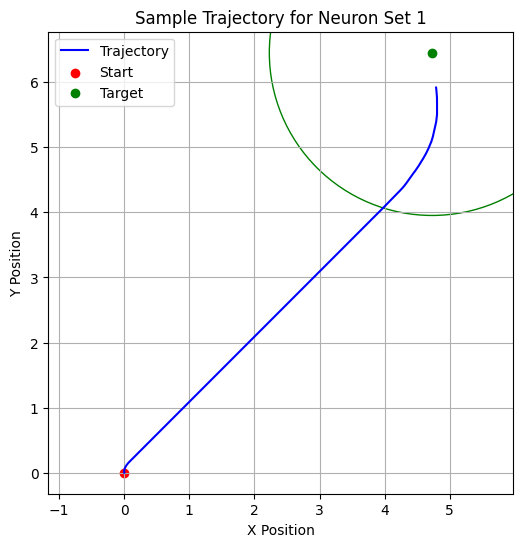

Successful trials: 50/50
Average simulated time: 1.794 seconds


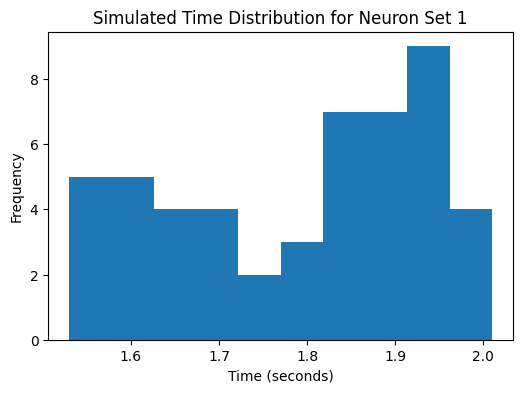


===== Neuron set 2: gc_neuron2.csv =====
Running benchmark


100%|██████████| 50/50 [04:00<00:00,  4.81s/it]


Successful trials: 50/50
Average time taken: 1.74 seconds
({'Footprint': 1544, 'ConnectionSparsity': 0.0, 'ActivationSparsity': 0.0, 'SynapticOperations': {'Effective_MACs': 0.0, 'Effective_ACs': 6757.16, 'Dense': 33384.96}}, 1.7388000000000003)


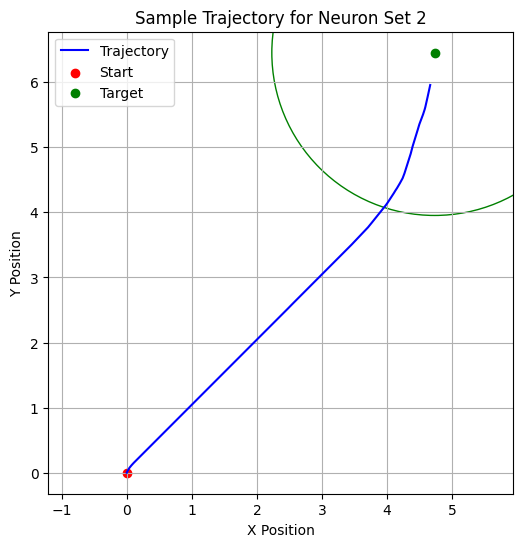

Successful trials: 50/50
Average simulated time: 1.793 seconds


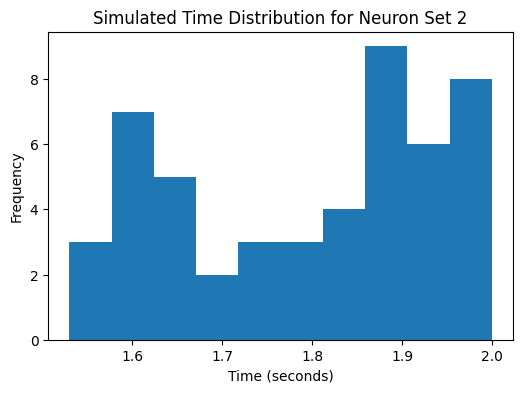


===== Neuron set 3: gc_neuron3.csv =====
Running benchmark


100%|██████████| 50/50 [03:58<00:00,  4.76s/it]


Successful trials: 50/50
Average time taken: 1.74 seconds
({'Footprint': 1544, 'ConnectionSparsity': 0.0, 'ActivationSparsity': 0.0, 'SynapticOperations': {'Effective_MACs': 0.0, 'Effective_ACs': 6812.0, 'Dense': 33465.6}}, 1.7430000000000003)


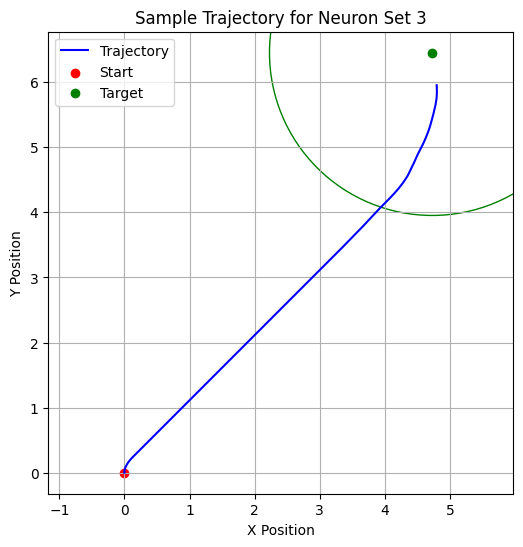

Successful trials: 50/50
Average simulated time: 1.796 seconds


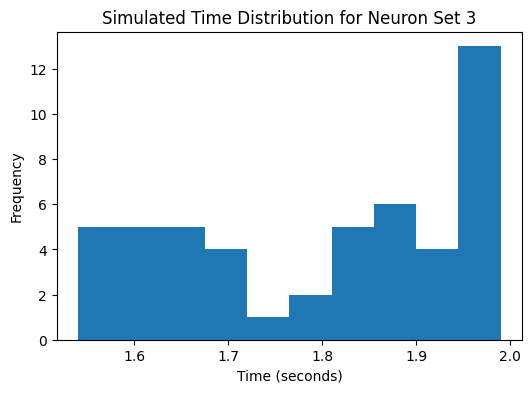

In [4]:
import os
import csv
import random
import numpy as np
import torch
import matplotlib.pyplot as plt
import time
from neurobench.envs import OPS, OPSEnv
from neurobench.benchmarks import BenchmarkClosedLoop
from neurobench.models.torch_model import TorchModel
from neurobench.metrics.static import Footprint, ConnectionSparsity
from neurobench.metrics.workload import ActivationSparsity, SynapticOperations

# Reproducible seed
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print("Using", device)

DT = 0.01
GAIN = 2.0
DAMP = 0.97
CLMP = 1.0

class PopVecDecoderFC(torch.nn.Module):
    """Population-vector decoder implemented as a frozen Linear layer."""
    def __init__(self, csv_file):
        super().__init__()
        dirs, lmin, lmax = [], [], []
        with open(csv_file) as f:
            for r in csv.reader(f):
                dirs.append([float(r[0]), float(r[1])])
                lmin.append(float(r[2]))
                lmax.append(float(r[3]))

        W = torch.tensor(dirs, dtype=torch.float32).t()  # (2,96)
        self.fc = torch.nn.Linear(96, 2, bias=False)
        with torch.no_grad():
            self.fc.weight.copy_(W)
        for p in self.fc.parameters():
            p.requires_grad = False  # freeze weights

        self.register_buffer("lmin", torch.tensor(lmin, dtype=torch.float32))
        self.register_buffer("lspan", torch.tensor(np.array(lmax) - np.array(lmin), dtype=torch.float32))
        self.register_buffer("vstate", torch.zeros(2))

    @torch.no_grad()
    def forward(self, obs):
        if isinstance(obs, (tuple, list)):
            obs = obs[0]
        lam = obs.view(-1).float() / DT
        prop = torch.clamp((lam - self.lmin) / self.lspan, 0., 1.)
        acc = self.fc(prop) * GAIN
        self.vstate.mul_(DAMP).add_(acc * DT).clamp_(-CLMP, CLMP)
        return self.vstate.clone()

def make_env(csv_path):
    ops = OPS(num_neurons=96, time_step=DT,
              upper_lmax=100, lower_lmax=40,
              upper_lmin=5, zero_prob=0.5,
              device=device)
    ops.assign_neurons(csv_path)
    return OPSEnv(ops=ops,
                  max_duration=3.0,
                  min_time_in_target=0.5,
                  side_radius=10,
                  min_distance=8,
                  target_size=2.5,
                  device=device)

base = "/Users/tkong/Documents/GitHub/neurobench/gc_neuron_list"
csv_files = [os.path.join(base, f"gc_neuron{i}.csv") for i in (1, 2, 3)]

static_metrics = [Footprint, ConnectionSparsity]
workload_metrics = [ActivationSparsity, SynapticOperations]

# Loop over neuron sets for benchmark and plots
for i, csv_path in enumerate(csv_files, 1):
    print(f"\n===== Neuron set {i}: {os.path.basename(csv_path)} =====")
    env = make_env(csv_path)
    model = TorchModel(PopVecDecoderFC(csv_path).to(device))
    bench = BenchmarkClosedLoop(model, env, False, [], [],
                                [static_metrics, workload_metrics])
    results = bench.run(nr_interactions=50, max_length=300, device=device)
    print(results)

    # Custom loop for histogram (50 trials) and one example trajectory
    trial_times_sim = []  # For histogram
    successful_trials = 0
    max_steps = 300

    # Run one trial for trajectory example
    positions = []
    obs = env.reset()
    if hasattr(env, 'cursor_position'):
        pos = env.cursor_position.clone().cpu().numpy()
    elif hasattr(env, 'position'):
        pos = env.position.clone().cpu().numpy()
    else:
        pos = np.zeros(2)  # Fallback
    positions.append(pos)

    # Get target
    if hasattr(env, 'target_position'):
        target = env.target_position.clone().cpu().numpy()
    elif hasattr(env, 'target'):
        target = env.target.clone().cpu().numpy()
    else:
        target = None  # Will approximate later

    done = False
    steps = 0
    while not done and steps < max_steps:
        action = model(obs)
        obs, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
        steps += 1
        # Log position
        if hasattr(env, 'cursor_position'):
            pos = env.cursor_position.clone().cpu().numpy()
        elif hasattr(env, 'position'):
            pos = env.position.clone().cpu().numpy()
        else:
            pos = np.zeros(2)
        positions.append(pos)

    sim_time = steps * DT
    trial_times_sim.append(sim_time)
    if terminated and not truncated and sim_time <= env.max_duration:
        successful_trials += 1

    # Plot trajectory
    positions = np.array(positions)
    plt.figure(figsize=(6, 6))
    plt.plot(positions[:, 0], positions[:, 1], 'b-', label='Trajectory')
    plt.scatter(positions[0, 0], positions[0, 1], c='r', label='Start')
    if target is not None:
        plt.scatter(target[0], target[1], c='g', label='Target')
        circle = plt.Circle((target[0], target[1]), env.target_size, color='g', fill=False)
        plt.gca().add_artist(circle)
    else:
        # Approximate target if not available
        if len(positions) > 1:
            final_pos = positions[-1]
            norm = np.linalg.norm(final_pos)
            if norm > 0:
                direction = final_pos / norm
                approx_target = direction * env.min_distance
                plt.scatter(approx_target[0], approx_target[1], c='g', label='Approx Target')
    plt.title(f'Sample Trajectory for Neuron Set {i}')
    plt.xlabel('X Position')
    plt.ylabel('Y Position')
    plt.legend()
    plt.grid(True)
    plt.axis('equal')
    plt.savefig(f'trajectory_set{i}.png')
    plt.show()

    # Continue with remaining 49 trials for histogram
    for _ in range(49):
        obs = env.reset()
        done = False
        steps = 0
        while not done and steps < max_steps:
            action = model(obs)
            obs, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            steps += 1
        sim_time = steps * DT
        trial_times_sim.append(sim_time)
        if terminated and not truncated and sim_time <= env.max_duration:
            successful_trials += 1

    print(f"Successful trials: {successful_trials}/50")
    print(f"Average simulated time: {np.mean(trial_times_sim):.3f} seconds")

    # Plot histogram
    plt.figure(figsize=(6, 4))
    plt.hist(trial_times_sim, bins=10)
    plt.title(f'Simulated Time Distribution for Neuron Set {i}')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Frequency')
    plt.savefig(f'histogram_set{i}.png')
    plt.show()